In [1]:
import xarray
import pandas

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb

In [3]:
nino34Domain=_index.sstIndex['nino34']

nino34Domain

{'latMin': -5, 'latMax': 5, 'longMin': 190, 'longMax': 240}

In [4]:
#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino34Box={
    'xy':[nino34Domain['longMin']-mapCentre, nino34Domain['latMin']],
    'width':nino34Domain['longMax']-nino34Domain['longMin'],
    'height':nino34Domain['latMax']-nino34Domain['latMin']
}

nino34Box

{'xy': [-20, -5], 'width': 50, 'height': 10}

# Load the sst dataset

In [36]:
paths = !find /scratch/w35/as2285/ersst/*.nc

In [38]:
xrLs=list()
for iPath in paths:
    xrLs.append(
        to_365day_monthly(
            xarray.open_dataset(iPath, use_cftime=True).isel(lev=0,drop=True)
        )
    )
sstXr=xarray.concat(xrLs,'time')

In [9]:
sstClimat=sst.calculateClimatology(sstXr.sst)

In [10]:
sstIndex=sst.calculateIndex(sstXr.sst, sstClimat)

In [11]:
indexXr=tp.averageForTimePeriod(sstIndex)

In [43]:
# and EC index too
sstAnoms=ec.sstAnoms(sstXr.sst, sstXr.sst)

#create the solver
solver=ec.eofSolver(sstAnoms)

#caluculate pcs and eofs
pcXr, pFit, eofsXr = ec.pcs(solver)

In [13]:
pcXr=pcXr/pcXr.std()

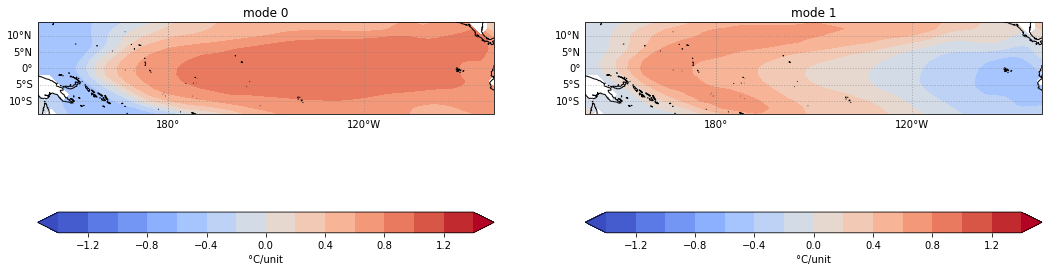

In [14]:
multiplyBy=[-1,1]

#Calc e and c
ecXr=xarray.Dataset()
ecXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
ecXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)

#Average over warmseason and store
allWarmSeasXr=tp.averageForTimePeriod(ecXr)

#first plots of pc1 and pc2
fig=plt.figure(figsize=(18,12))
for mode in [0,1]:
    ax=fig.add_subplot(1,2,mode+1,
                   projection=ccrs.Miller(central_longitude=mapCentre))
    ec.ensoPlotter(
        multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
    plt.title("mode " + str(mode))
plt.show()

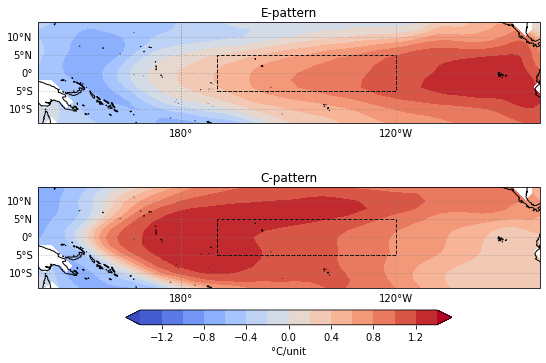

In [15]:
#then plots of e pattern and c pattern
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(2,1,1,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(
    multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
    ax, colorbar=False)
ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))

plt.draw()
plt.title("E-pattern")

ax=fig.add_subplot(2,1,2,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
plt.title("C-pattern")
plt.savefig('results/ecPattern.png')
plt.show()


In [16]:
indexXr=xarray.merge([indexXr,allWarmSeasXr])

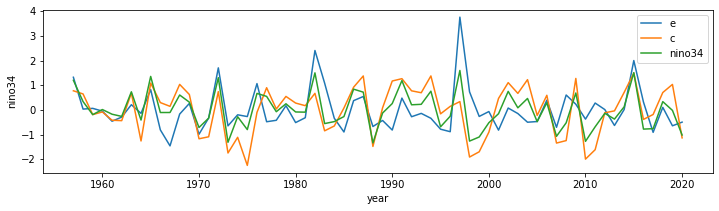

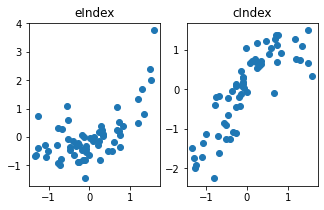

In [17]:
#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.eIndex.plot()
indexXr.cIndex.plot()
indexXr.nino34.plot()

#plt.xlim([1950,2050])
plt.legend(['e','c','nino34'])
plt.show()

#scatter plots
fig = plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.scatter(indexXr.nino34, indexXr.eIndex)
plt.title('eIndex')

plt.subplot(1,3,2)
plt.scatter(indexXr.nino34, indexXr.cIndex)
plt.title('cIndex')

plt.show()

# Marshall SAM

In [18]:
marshallPd=pandas.read_csv(
    'ref/marshallSam/newsam.1957.2007.txt',
    sep=' ', 
    skipinitialspace=True
)

In [19]:
marshallPd

JAN   FEB   MAR   APR   MAY   JUN   JUL   AUG   SEP   OCT   NOV   DEC
1957 -0.87 -2.27  0.07 -1.97 -2.50 -0.87  1.00 -1.73  0.72 -3.12 -5.42 -2.63
1958  0.04 -2.84 -2.52 -0.30 -2.72 -0.97 -1.65  0.97  1.90 -0.16  0.30  0.82
1959  1.59 -0.19 -0.54 -1.25 -0.32 -1.12  0.18 -1.64  2.46 -0.46  3.28 -0.38
1960  0.90  0.85  3.40 -0.35 -0.60 -0.17  0.31  0.43  1.41 -1.17  1.18  1.36
1961  0.91 -4.00 -0.40 -0.14  1.12 -0.40  0.98  1.10 -1.21  1.64  1.52  2.32
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
2017 -1.12 -1.09 -1.56  1.65  1.82  1.98  0.16  0.31  0.42 -0.64  3.18  1.44
2018  2.72  1.02 -0.03 -1.66  0.01 -1.57  0.55 -0.78  1.83  2.76  2.84  1.44
2019  2.79 -1.87  1.47  0.86 -0.11  2.21 -2.20 -2.04  0.81 -1.97 -4.42 -1.78
2020  0.57 -0.36  2.05 -1.72  1.03  1.18 -0.97 -2.20 -0.25  1.79  1.14  2.28
2021  1.95  2.19 -0.95  0.87  0.75  1.88   NaN   NaN   NaN   NaN   NaN   NaN

[65 rows x 12 columns]

In [20]:
marshallXr=marshallPd.to_xarray().to_array('month').rename({'index':'year'})

In [42]:
indexXr['samSummer']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['OCT','NOV','DEC']
    ).sum('month')  #This is the sep to dec sum for each year
    + marshallXr.sel(
        year=range(1958,2022),
        month=['JAN','FEB','MAR']
    ).sum('month')   #This is the jan feb sum for the next year
)/6

indexXr['samWinter']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['APR','MAY','JUN','JUL','AUG','SEP']
    ).sum('month') 
)/6

In [43]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables: (12/14)
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502
    eastIONoDetrend         (year) float64 -0.2096 0.2706 ... -0.5503 0.4041
    dmi                     (year) float64 -0.2578 -0.656 ... 1.441 0.01628
    nino34                  (year) float64 1.198 0.3367 ... -0.02116 -1.019
    eastIO                  (year) float64 -0.1259 0.4451 ... -1.003 0.1331
    backgroundSstNoDetrend  (year) float64 -0.01563 -0.1544 ... 0.5034 0.1919
    ...                      ...
    nino4                   (year) float64 0.4491 0.2838 ... 0.4623 -0.6939
    cIndex                  (year) float64 0.7737 0.6456 ... 1.031 -1.135
    eIndex                  (year) float64 1.321 0.03133 ... -0.6455 -0.4974
    sam                     (year) float64 -2.208 0.71 1.108 ... -1.192 1.517
    samSummer               (year) float64 nan -0.7267 0.55 ... -0.9633 1.245
    samWinter               (year) float64 -0.8917 -0.4617 ... -0.07833 -0.4883

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [23]:
stdXr=indexXr.std()

In [44]:
criteriaXr=stdXr[['dmi','nino34', 'eastIO', 'eIndex', 'cIndex']]
criteriaXr['samWinter']=stdXr.sam/2
criteriaXr['samSummer']=stdXr.sam/2

In [45]:
criteriaXr

<xarray.Dataset>
Dimensions:    ()
Data variables:
    dmi        float64 0.4737
    nino34     float64 0.7333
    eastIO     float64 0.388
    eIndex     float64 0.8552
    cIndex     float64 0.9766
    samWinter  float64 0.5089
    samSummer  float64 0.5089

In [46]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['eIndex', 'samWinter', 'dmi', 'nino34', 'cIndex']
fireNeg: 
['eastIO', 'samSummer']


In [47]:
firePosXr

<xarray.Dataset>
Dimensions:    (year: 64)
Coordinates:
  * year       (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
Data variables:
    eIndex     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    samWinter  (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 0.0
    dmi        (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 1.0 0.0
    nino34     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cIndex     (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    eastIO     (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    samSummer  (year) float64 nan 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0

In [48]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [49]:
eventsXr['ecCombined']=eventsXr[['eIndex','cIndex']].to_array().any('variable')*1.0

In [50]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    eIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 1.0
    cIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    samSummer   (fire, year) float64 nan 1.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0

In [51]:
eventsXr.to_netcdf('results/obsEvents.nc')

In [52]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    eIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 1.0
    cIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    samSummer   (fire, year) float64 nan 1.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0

In [53]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

eIndex : [1957 1972 1976 1982 1983 1997 2015]
samWinter : [1967 1976 1979 1982 1985 1989 1993 1997 1998 1999 2001 2003 2004 2010
 2012 2015 2016 2017]
dmi : [1961 1963 1967 1972 1994 1997 2006 2012 2015 2018 2019]
nino34 : [1957 1965 1972 1982 1986 1991 1994 1997 2002 2015]
cIndex : [1965 1968 1987 1990 1991 1994 2002 2004 2009 2015 2019]
eastIO : [1961 1963 1972 1994 1997 2006 2019]
samSummer : [1958 1964 1965 1966 1967 1968 1969 1972 1975 1976 1977 1980 1984 1986
 1987 1988 2002 2019]
ecCombined : [1957 1965 1968 1972 1976 1982 1983 1987 1990 1991 1994 1997 2002 2004
 2009 2015 2019]


Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
They seem to match ok

Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (bad)


# Check events against the initial SSTs:

In [81]:
ensoSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='nino34'))
iodSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='dmi'))

In [87]:
%run helpers/impactPlots.ipynb

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>]

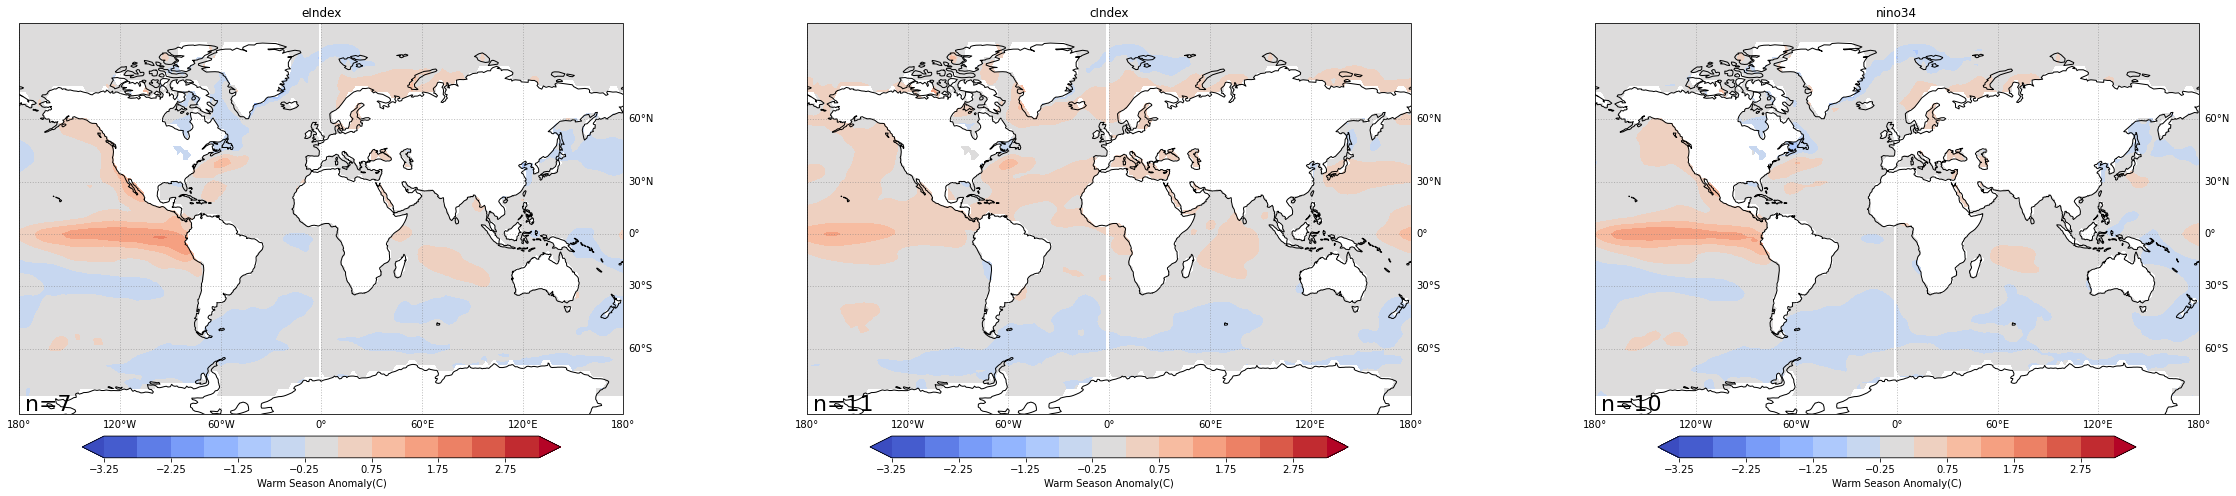

In [88]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['eIndex','cIndex','nino34'],
    showOcean=False
)

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>]

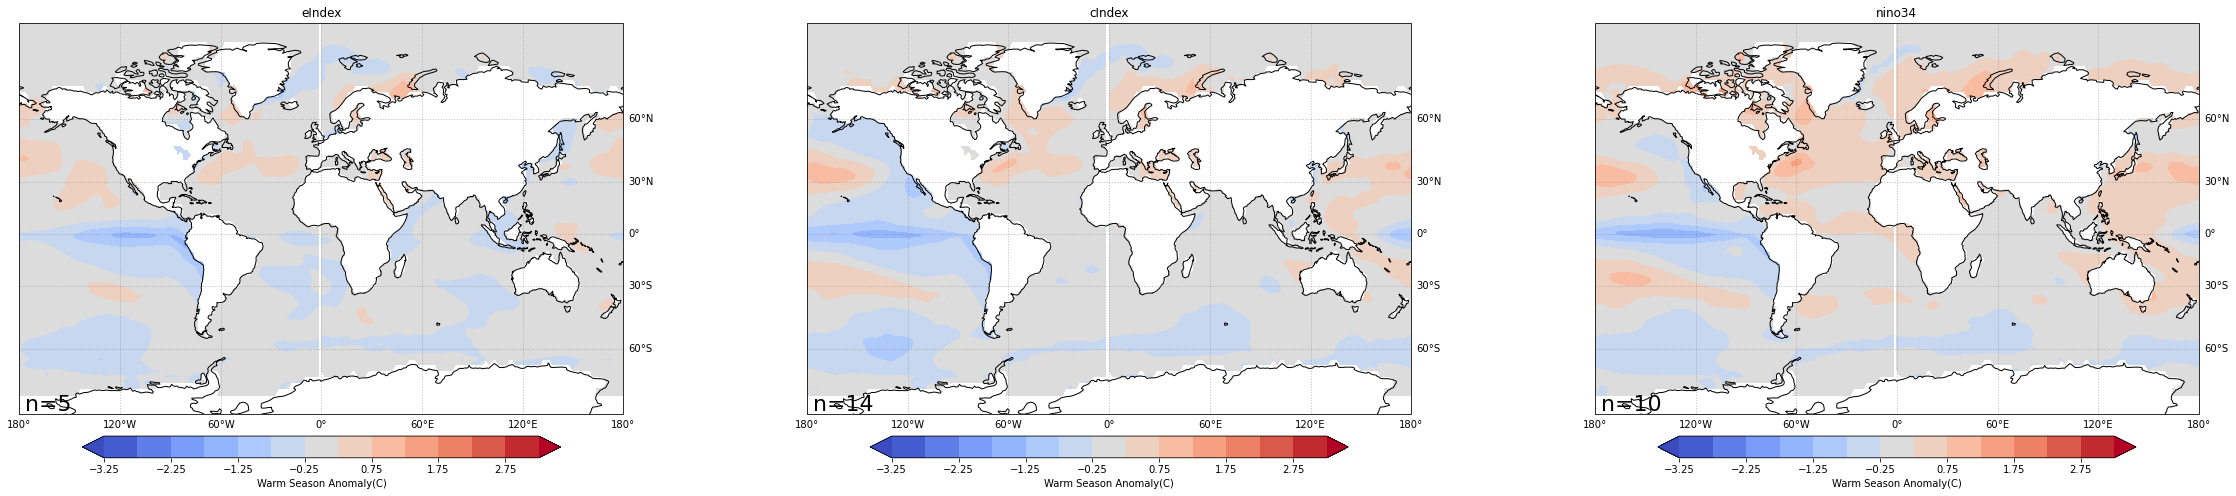

In [89]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['eIndex','cIndex','nino34'],
    showOcean=False
)

[<GeoAxesSubplot:title={'center':'dmi'}>]

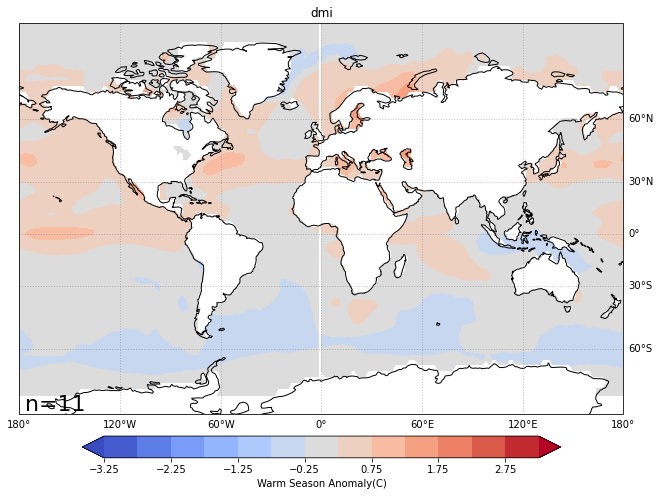

In [90]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['dmi'],
    showOcean=False
)

[<GeoAxesSubplot:title={'center':'dmi'}>]

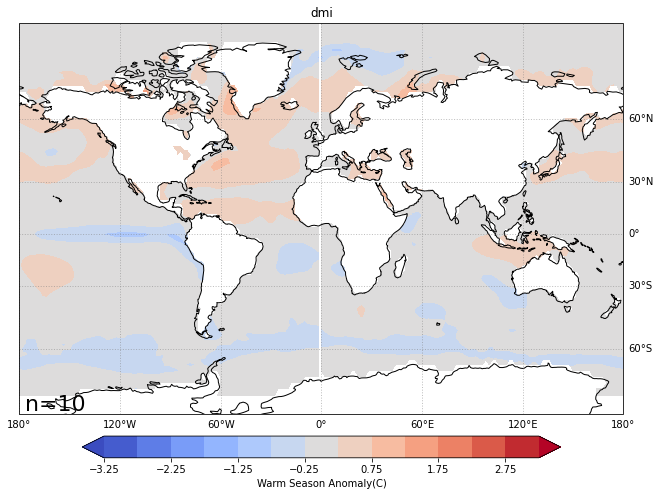

In [91]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['dmi'],
    showOcean=False
)

# If we plot some impact maps now, do they look plausible?

In [3]:
eventsXr=xarray.load_dataset('results/obsEvents.nc')

In [4]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire        (fire) object 'pos' 'neg'
Data variables:
    eIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 1.0
    cIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    samSummer   (fire, year) float64 nan 1.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0

In [5]:
prTWarmSeasonXr = xarray.load_dataset('results/observPrTmaxAnoms.nc')

In [6]:
prTWarmSeasonXr

<xarray.Dataset>
Dimensions:       (lat: 691, lon: 886, year: 120)
Coordinates:
  * lat           (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon           (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * year          (year) int64 1900 1901 1902 1903 1904 ... 2016 2017 2018 2019
Data variables:
    tsAnomWinter  (year, lat, lon) float32 nan nan nan ... -0.03632 -0.03523
    tsAnomSummer  (year, lat, lon) float32 nan nan nan ... 0.04448 0.04579
    prAnomWinter  (year, lat, lon) float64 5.921e-16 0.0 ... 0.0004324 0.0004152
    prAnomSummer  (year, lat, lon) float64 0.0004444 0.000446 ... -0.06802
    prWinter      (lat, lon) float64 11.01 11.0 11.0 10.99 ... 5.803 5.816 5.827
    prSummer      (lat, lon) float64 2.243 2.243 2.243 ... 9.215 9.224 9.23
    tsWinter      (lat, lon) float32 11.12 11.13 11.13 ... 28.14 28.13 28.12
    tsSummer      (lat, lon) float32 8.469 8.476 8.482 ... 29.48 29.47 29.46

In [113]:
eventsLs = {
    'summer':['eIndex', 'cIndex', 'ecCombined', 'nino34','dmi','samSummer'],
    'winter':['eIndex', 'cIndex', 'ecCombined', 'nino34','dmi','samWinter']
}

# Anoms for indiv indices - Fire Pos

In [111]:
%run helpers/impactPlots.ipynb

pos
winter


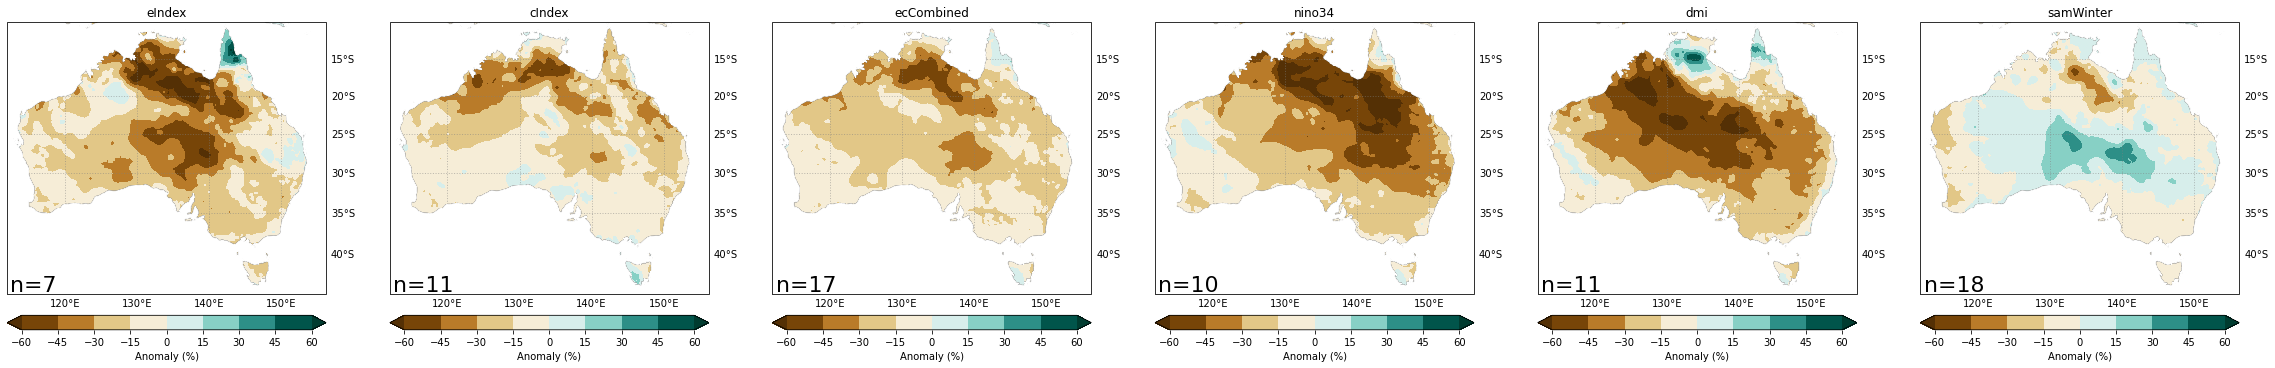

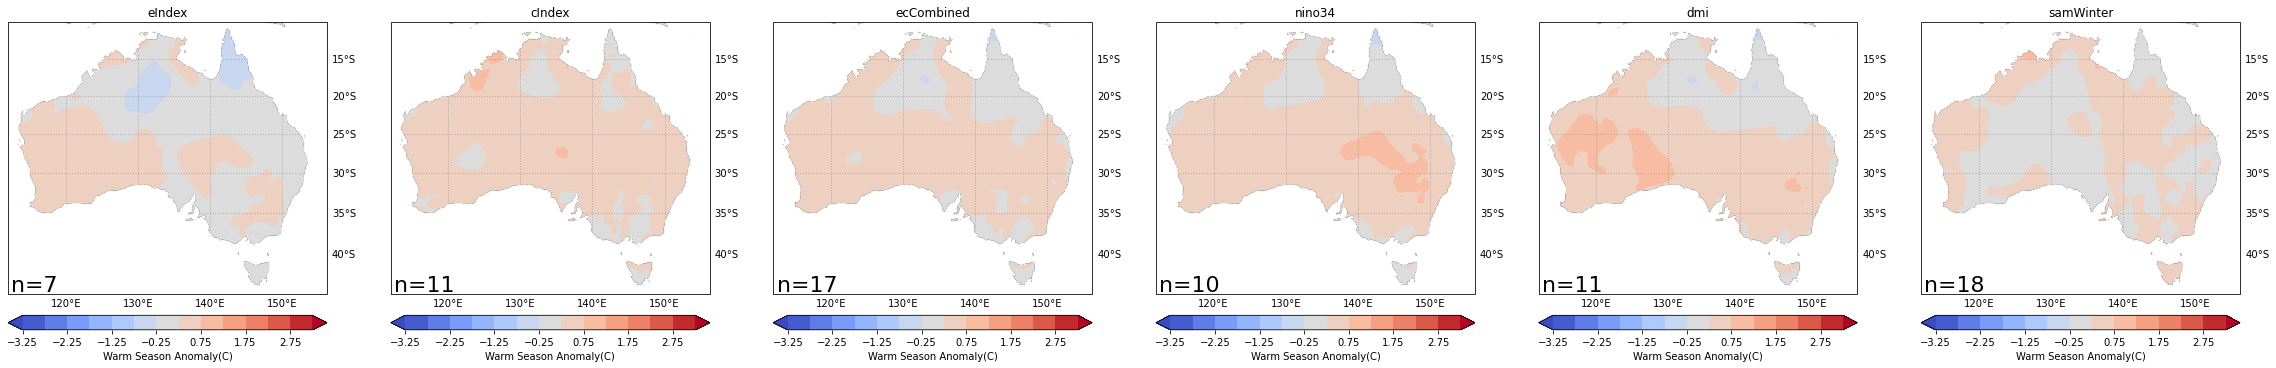

summer


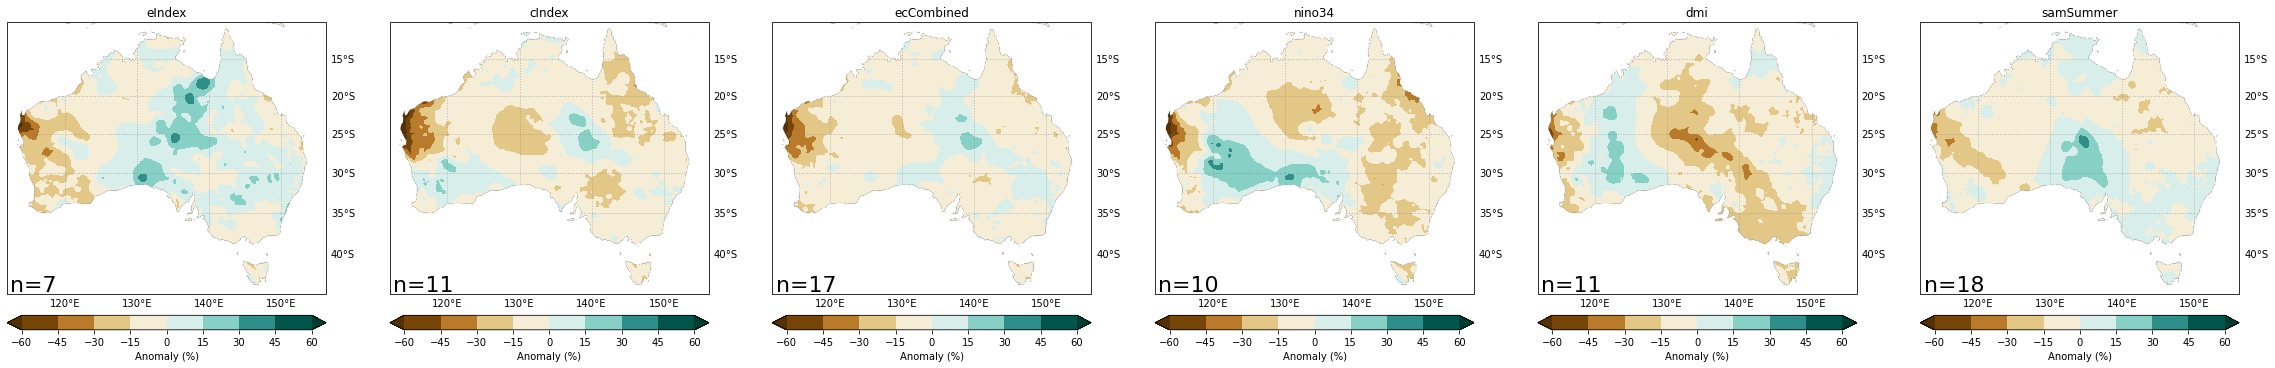

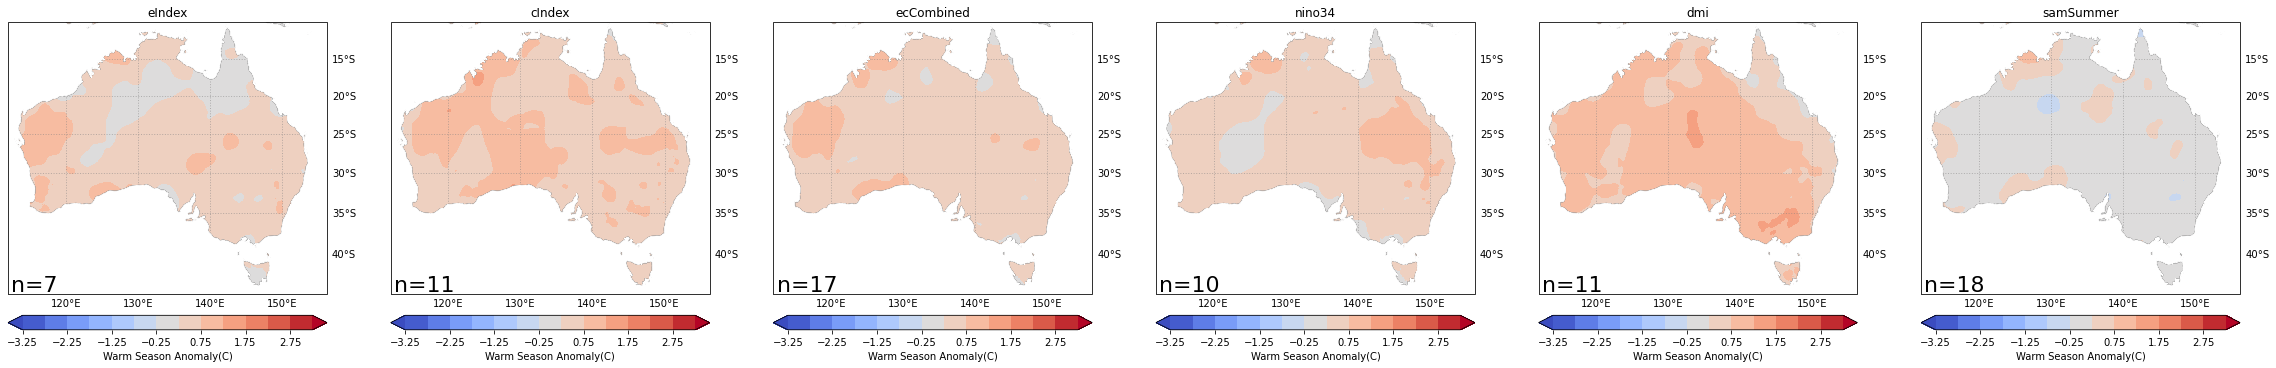

neg
winter


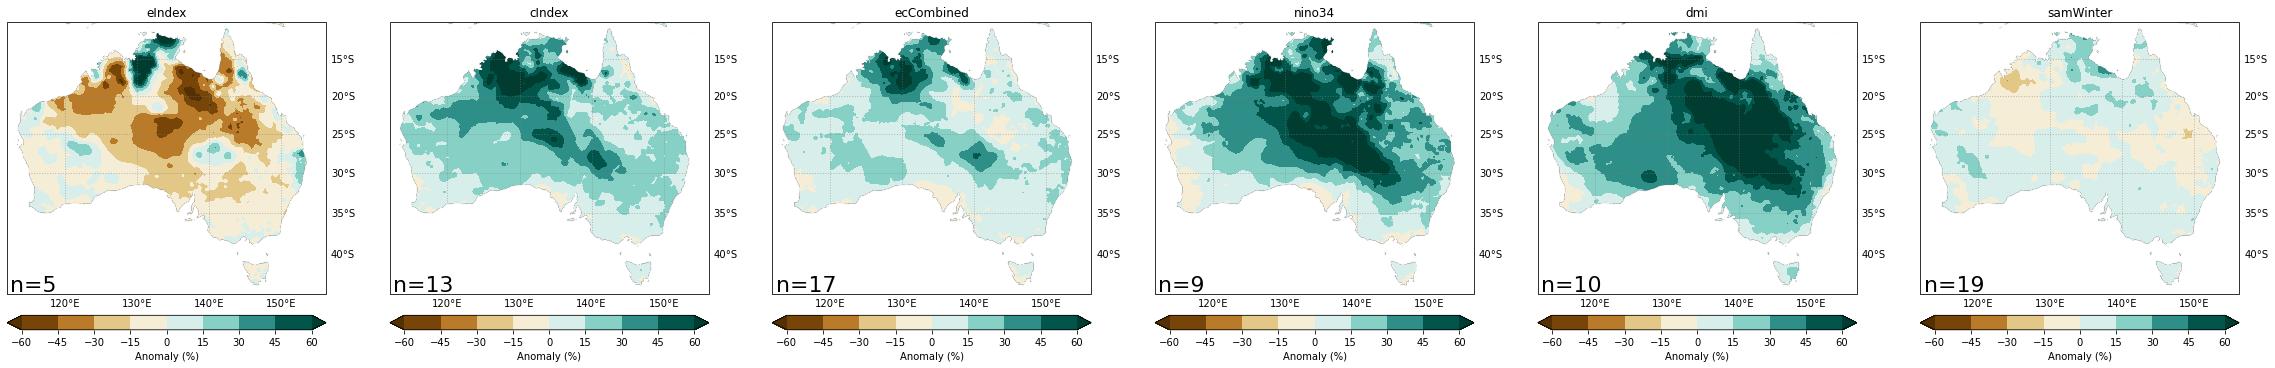

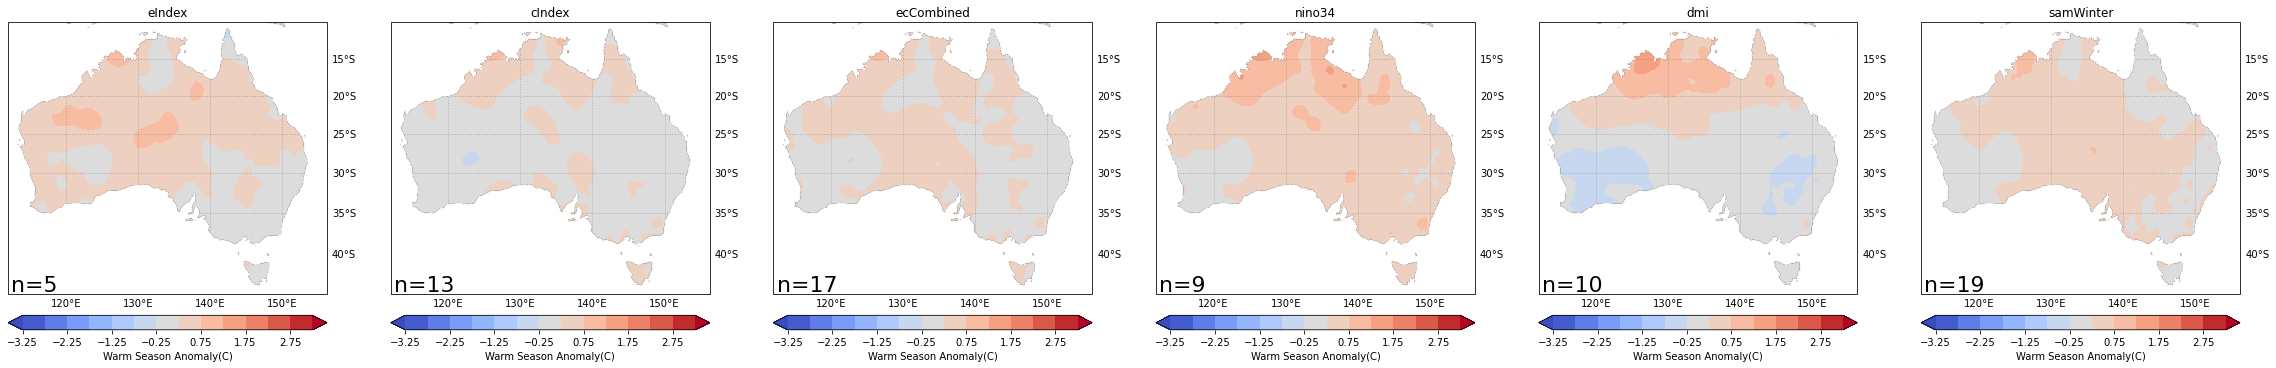

summer


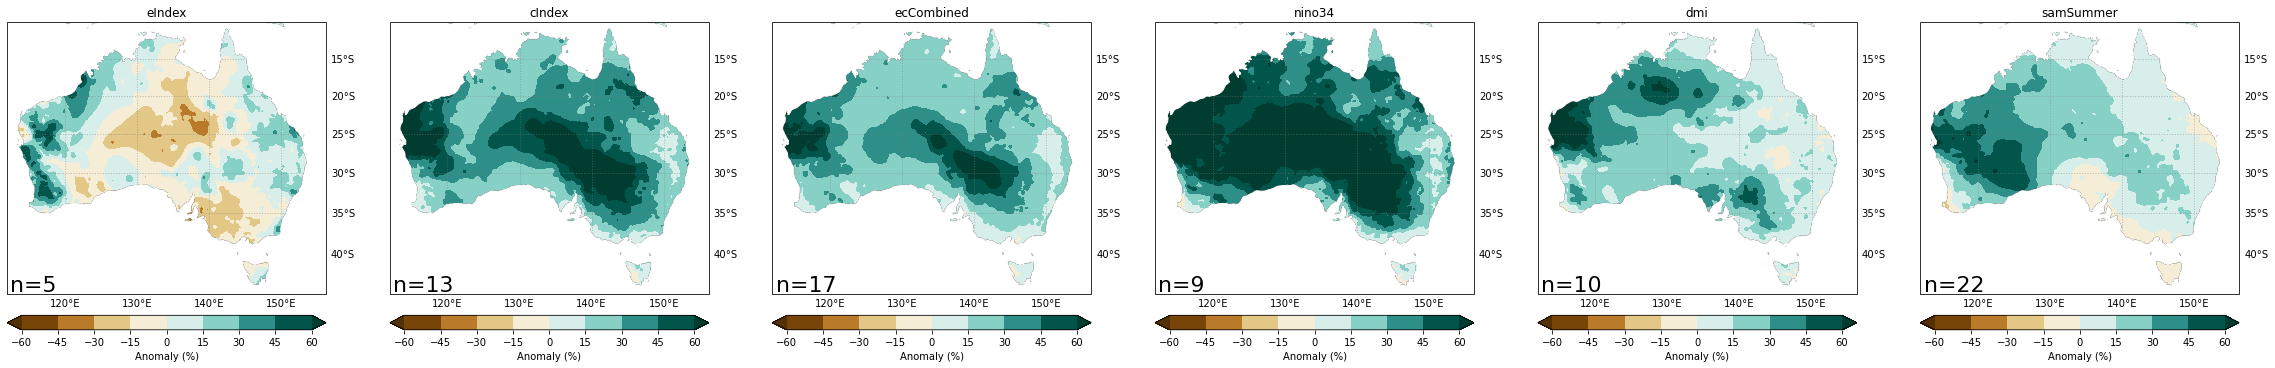

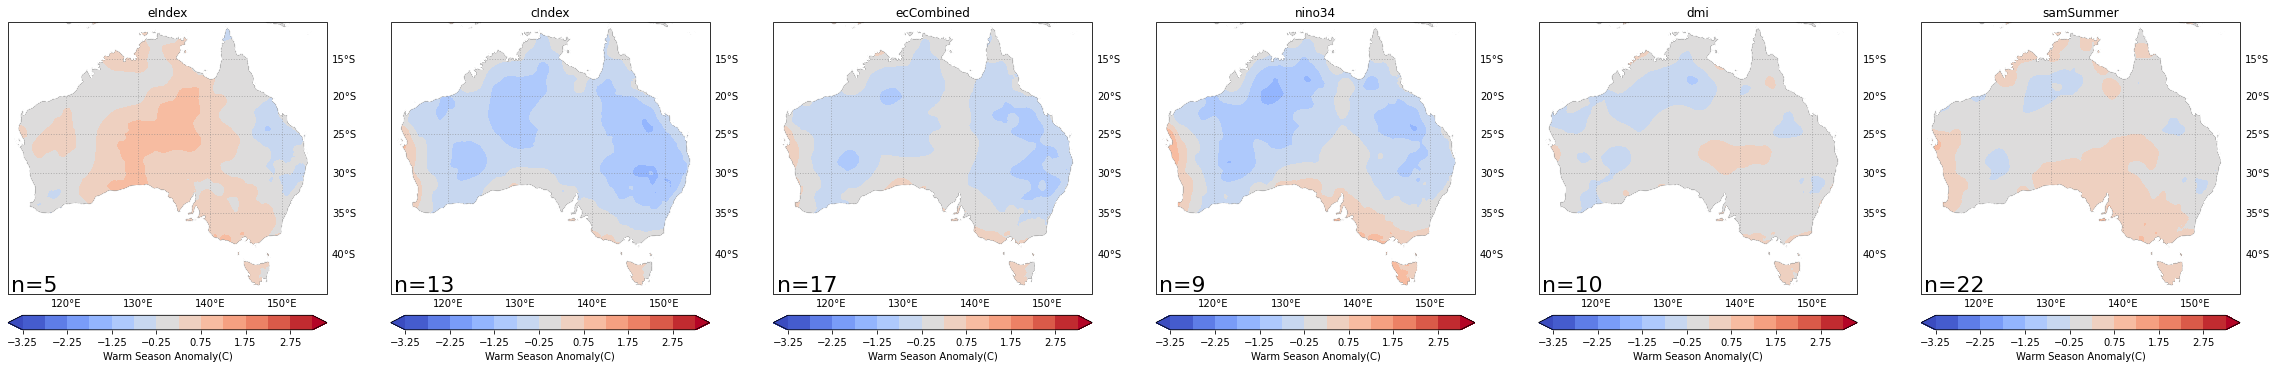

In [117]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason]
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason]
        )
        plt.show()

# Compound them and see what happens

In [100]:
compoundEventsXr=compound.compound(eventsXr)

nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedEastioSamwinter
ecCombinedEastioSamsummer
cIndexDmiSamwinter
cIndexDmiSamsummer
cIndexEastioSamwinter
cIndexEastioSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
eIndexEastioSamwinter
eIndexEastioSamsummer


In [101]:
indexSet='ecCombinedDmiSam'

In [118]:
compoundEventsLs=[*compoundEventsXr.indeces,*compoundEventsXr.pairs, 'all3']

In [119]:
compoundEventsLs

['enso', 'iod', 'sam', 'enso+iod', 'enso+sam', 'iod+sam', 'all3']

In [105]:
#enso+iod compound years, realWorld

for iCompound in compoundEventsLs:

    years=compoundEventsXr.where(
        compoundEventsXr[indexSet].sel(fire='pos', compound=iCompound)==True, 
        drop=True
    ).year.values
    
    print(str(iCompound) + ' : ' + str(years))

enso+iod : [1994 1997 2015]
enso+sam : [1965 1968 1976 1987 2002]
iod+sam : [1967]
all3 : [1972 2019]


pos
winter


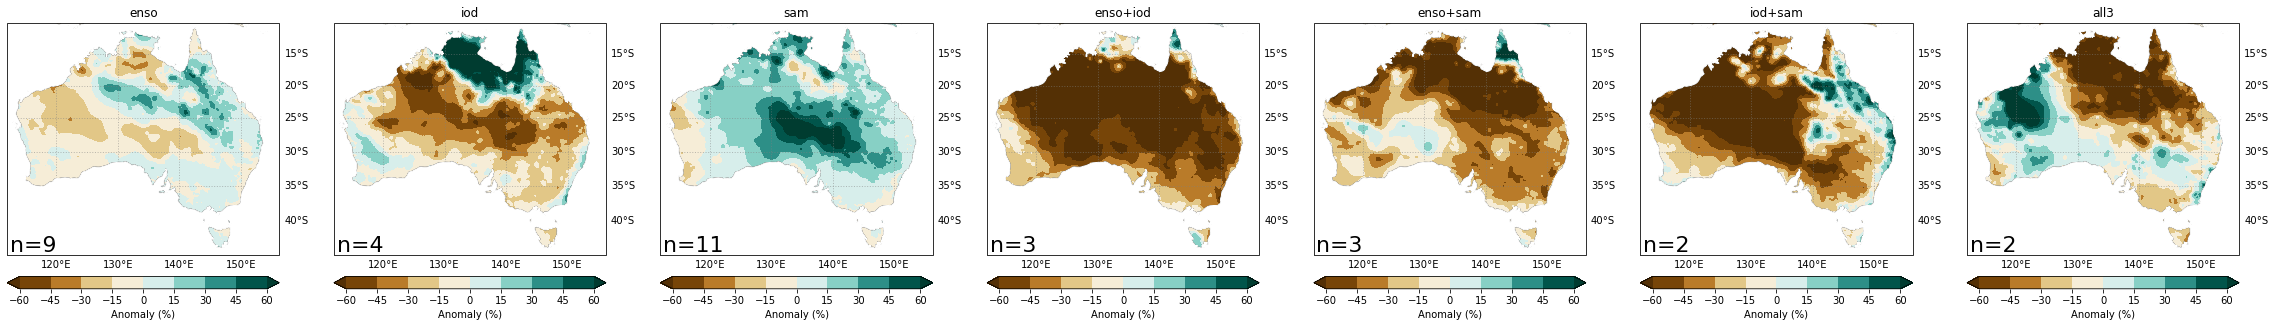

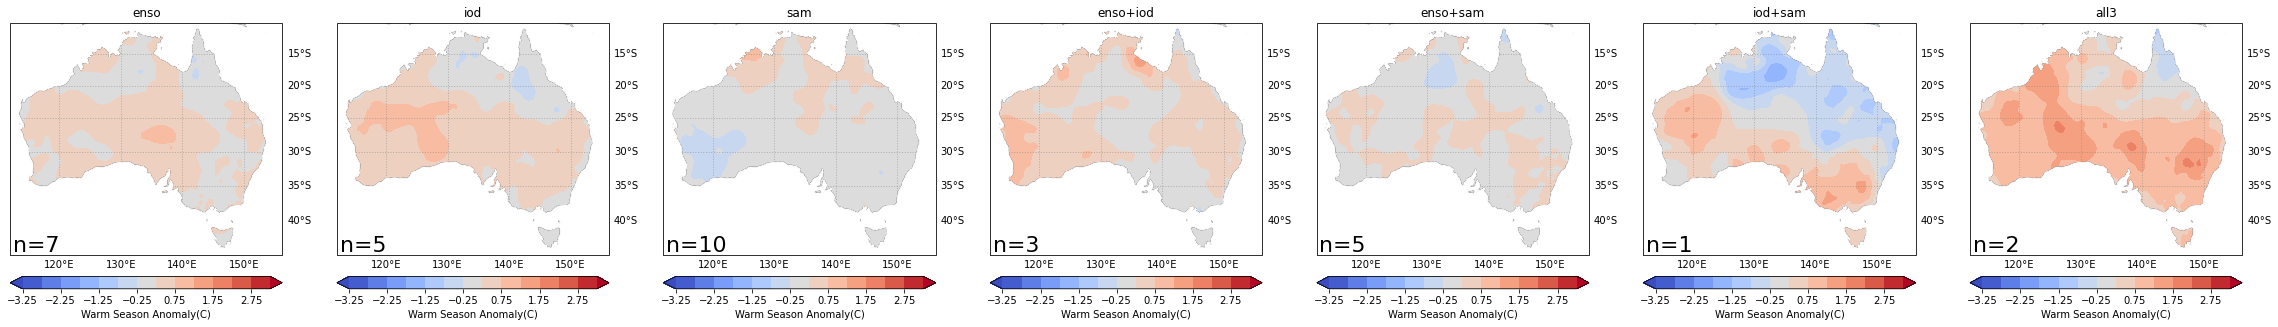

summer


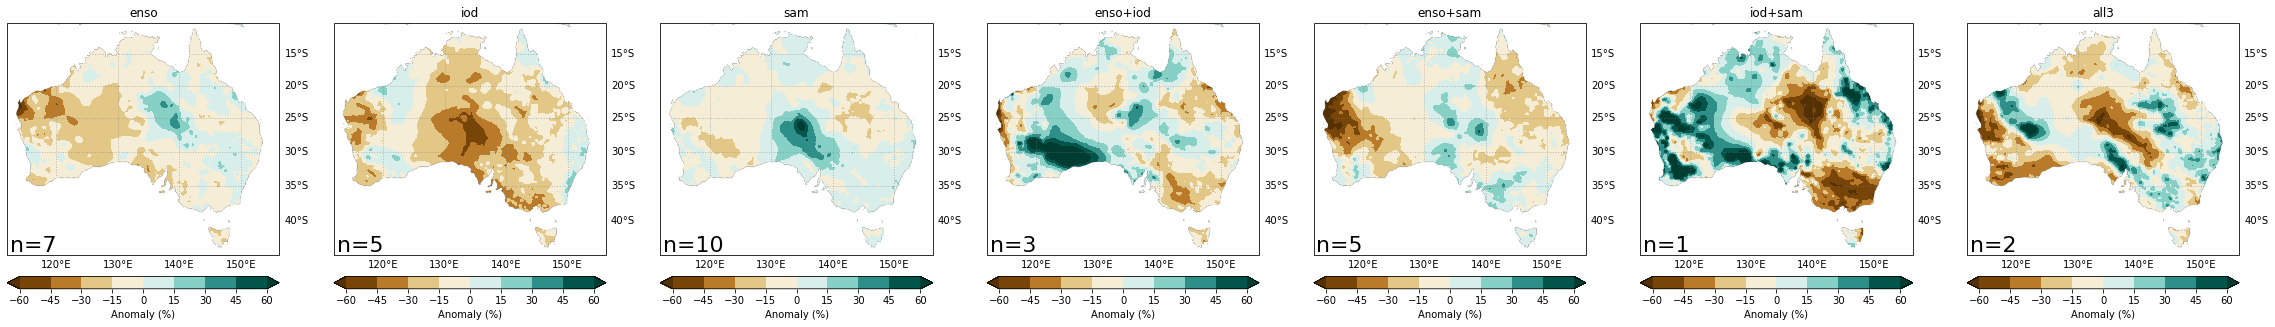

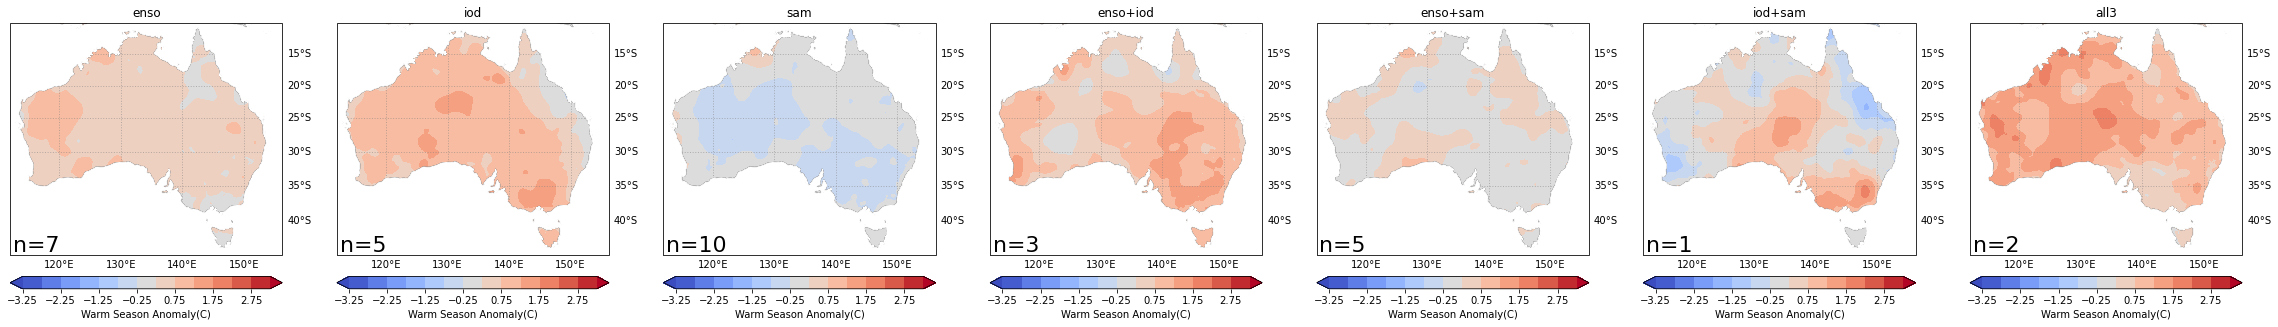

neg
winter


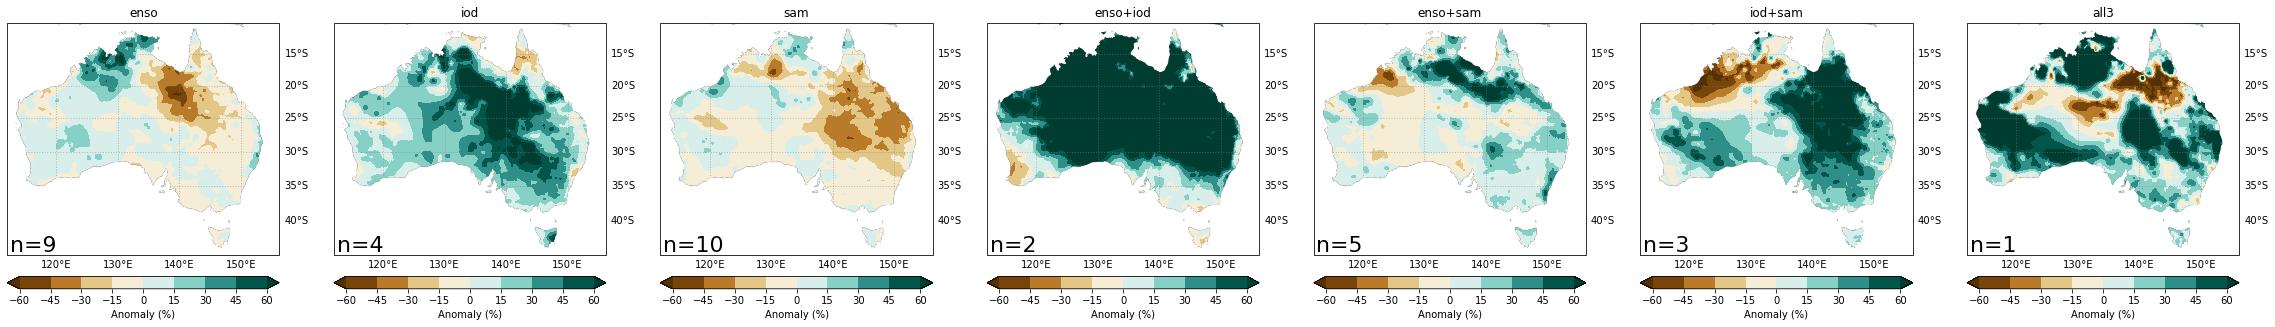

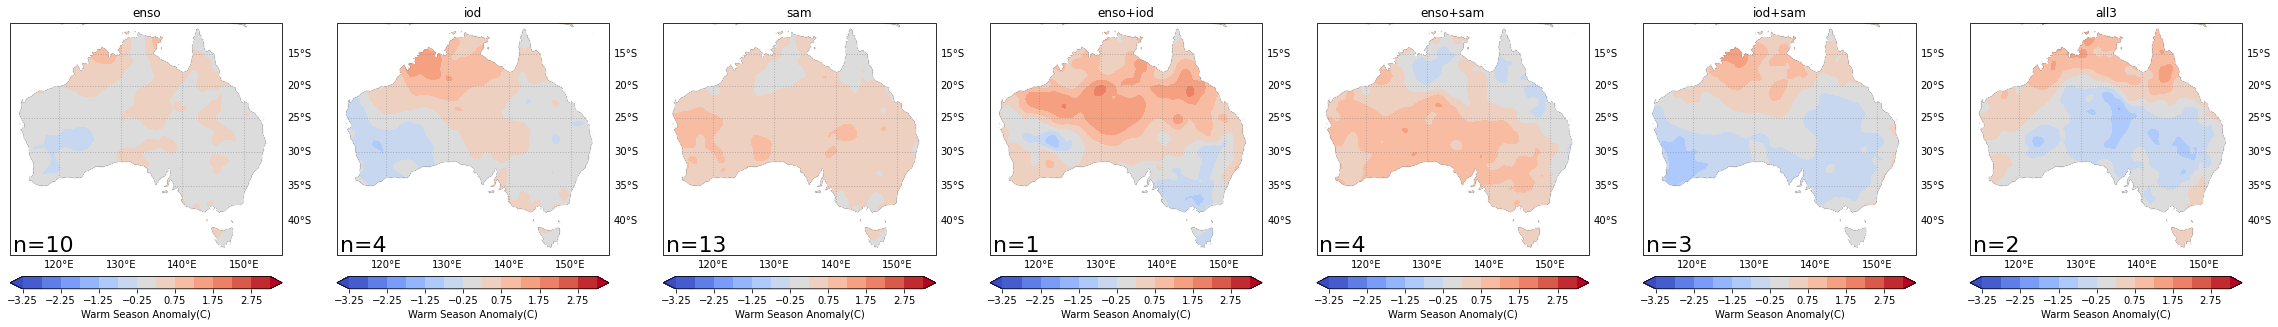

summer


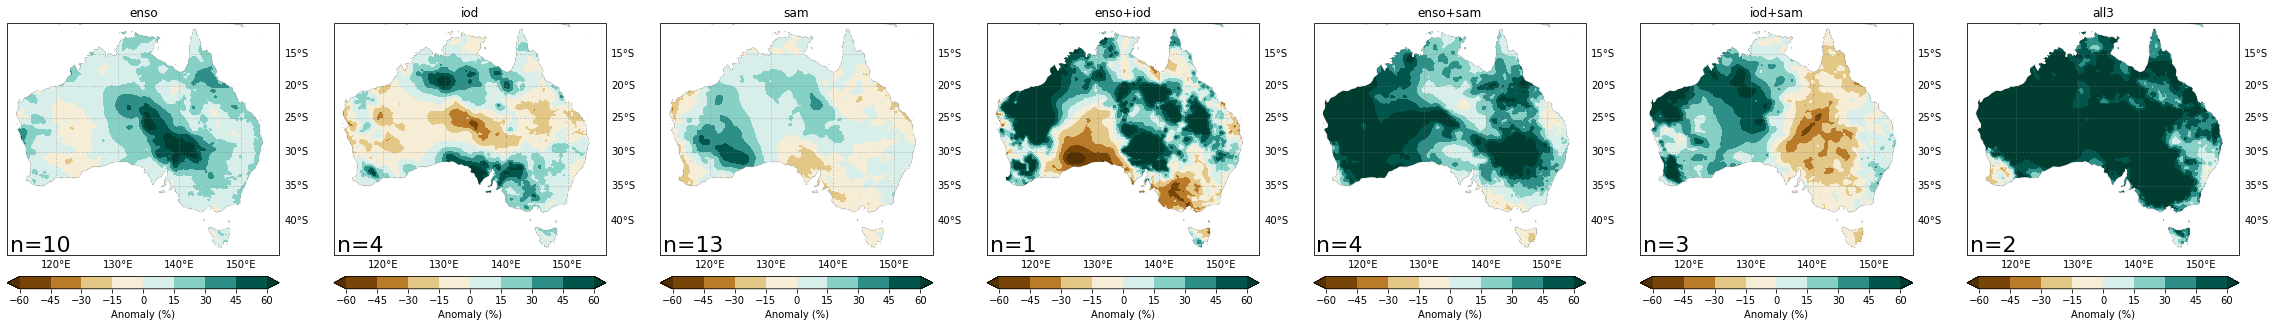

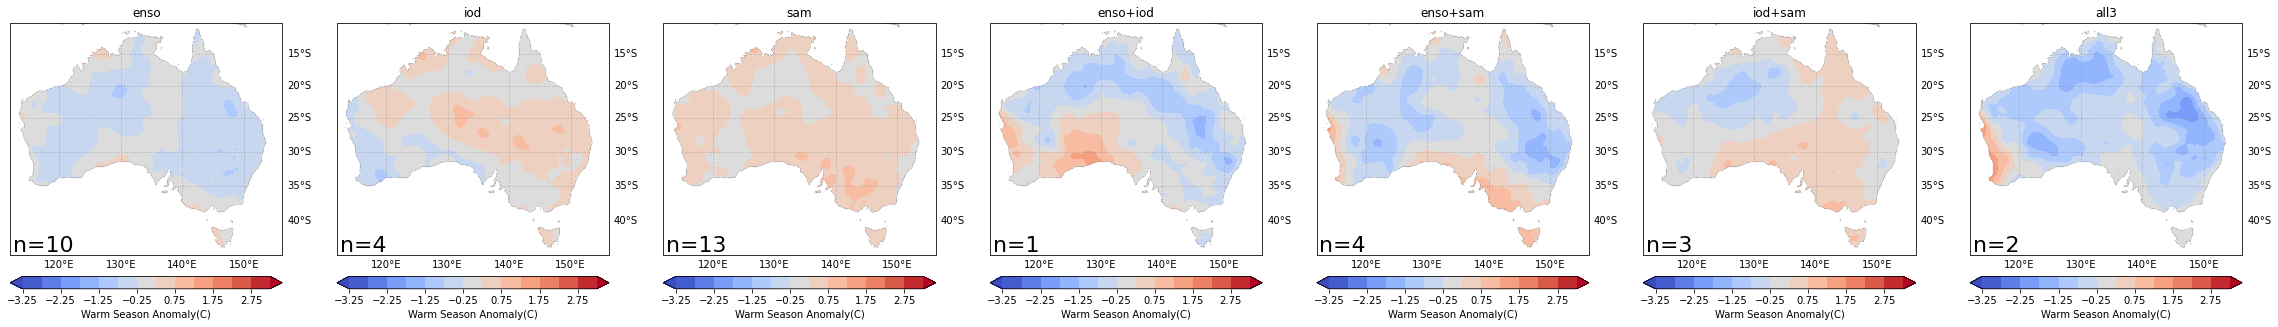

In [120]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            compoundEventsXr['ecCombinedDmiSam'+iSeason].sel(fire=iFire, drop=True).to_dataset('compound'), 
            compoundEventsLs
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            compoundEventsXr[indexSet].sel(fire=iFire, drop=True).to_dataset('compound'), 
            compoundEventsLs
        )
        plt.show()

# And comparison between the three enso indices

In [122]:
ensoIodEventsXr=compoundEventsXr.sel(compound='enso+iod', drop=True)

In [123]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [124]:
ensoIodEventsLs

['nino34DmiSamwinter',
 'nino34DmiSamsummer',
 'nino34EastioSamwinter',
 'nino34EastioSamsummer',
 'ecCombinedDmiSamwinter',
 'ecCombinedDmiSamsummer',
 'ecCombinedEastioSamwinter',
 'ecCombinedEastioSamsummer',
 'cIndexDmiSamwinter',
 'cIndexDmiSamsummer',
 'cIndexEastioSamwinter',
 'cIndexEastioSamsummer',
 'eIndexDmiSamwinter',
 'eIndexDmiSamsummer',
 'eIndexEastioSamwinter',
 'eIndexEastioSamsummer']

In [133]:
ensoIodEventLs=[
    'ecCombinedDmiSam',
    'cIndexDmiSam',
    'eIndexDmiSam',
    'nino34DmiSam'
]


pos
winter


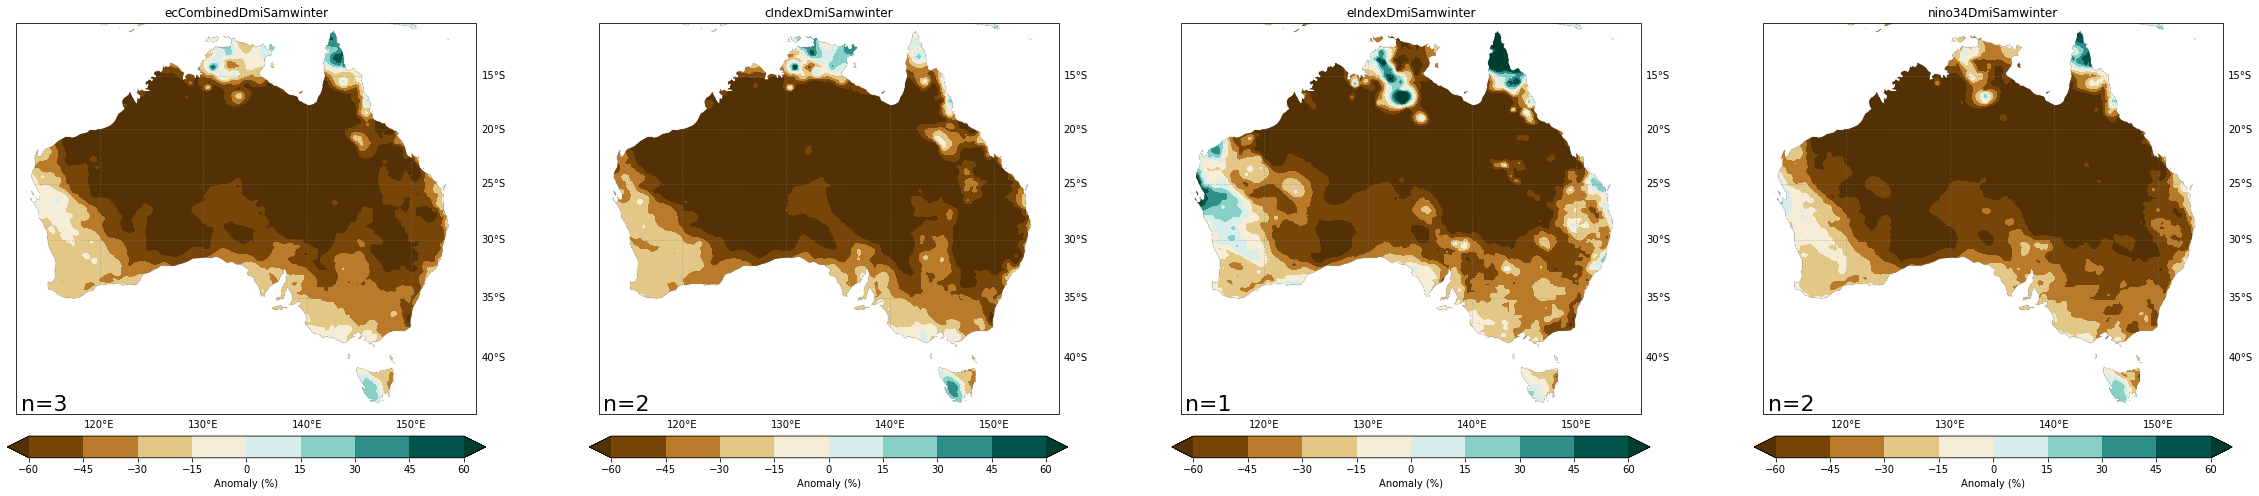

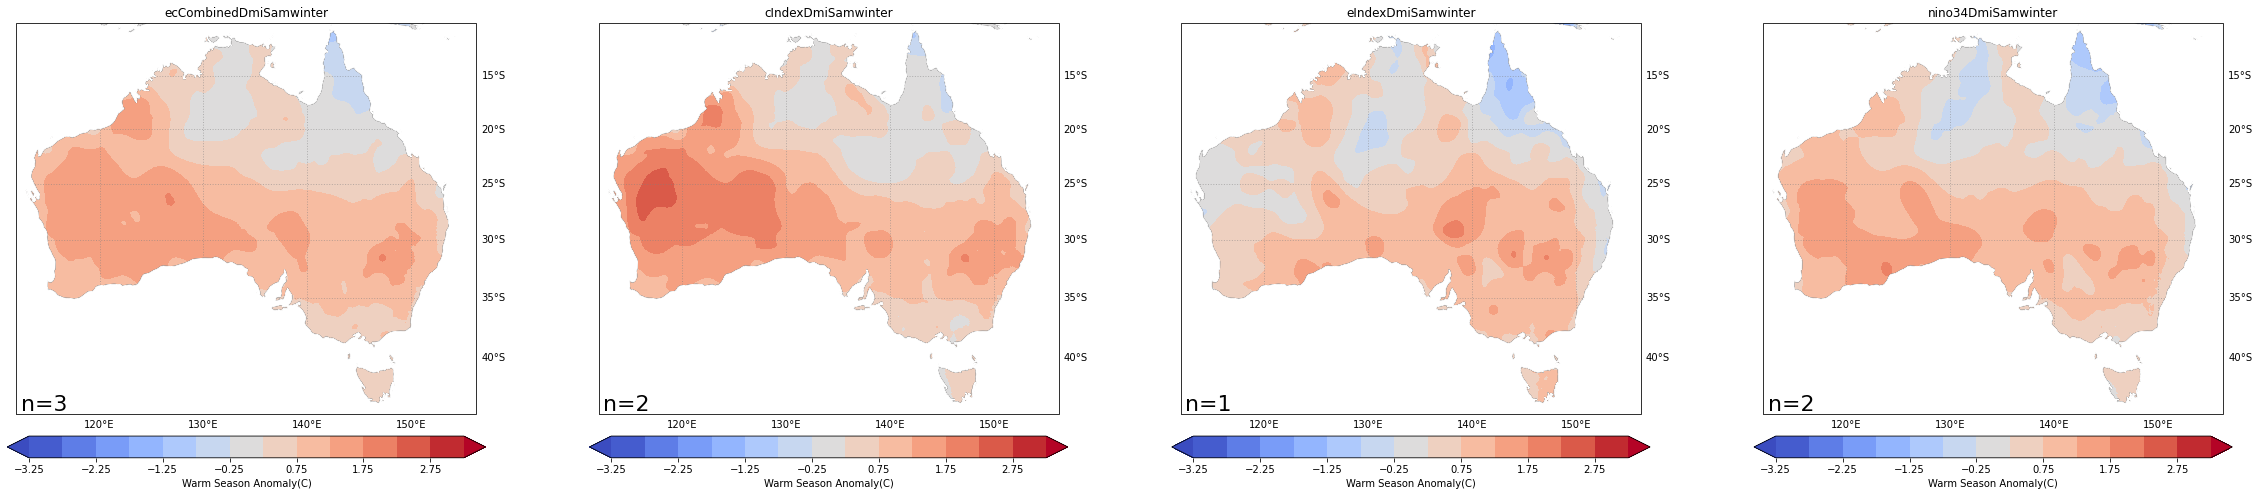

summer


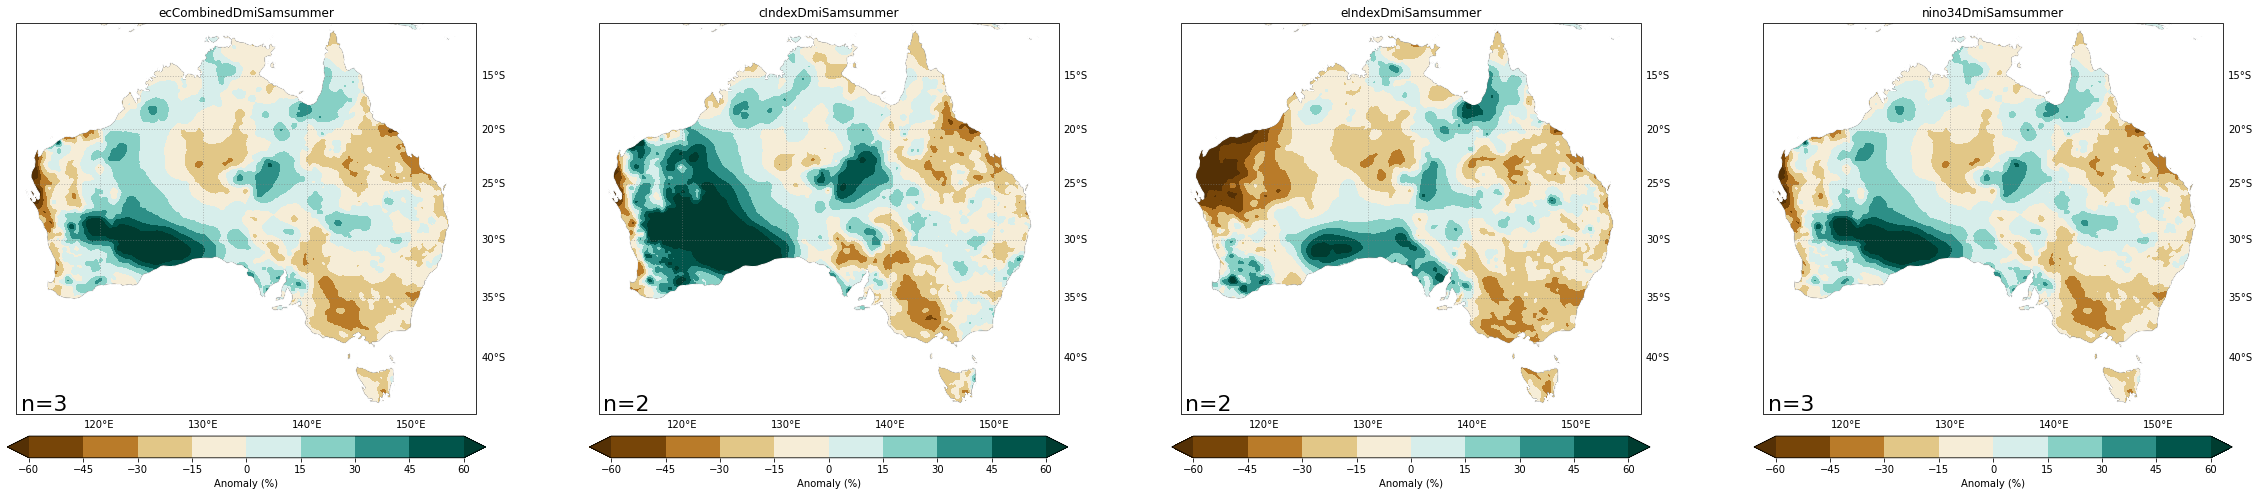

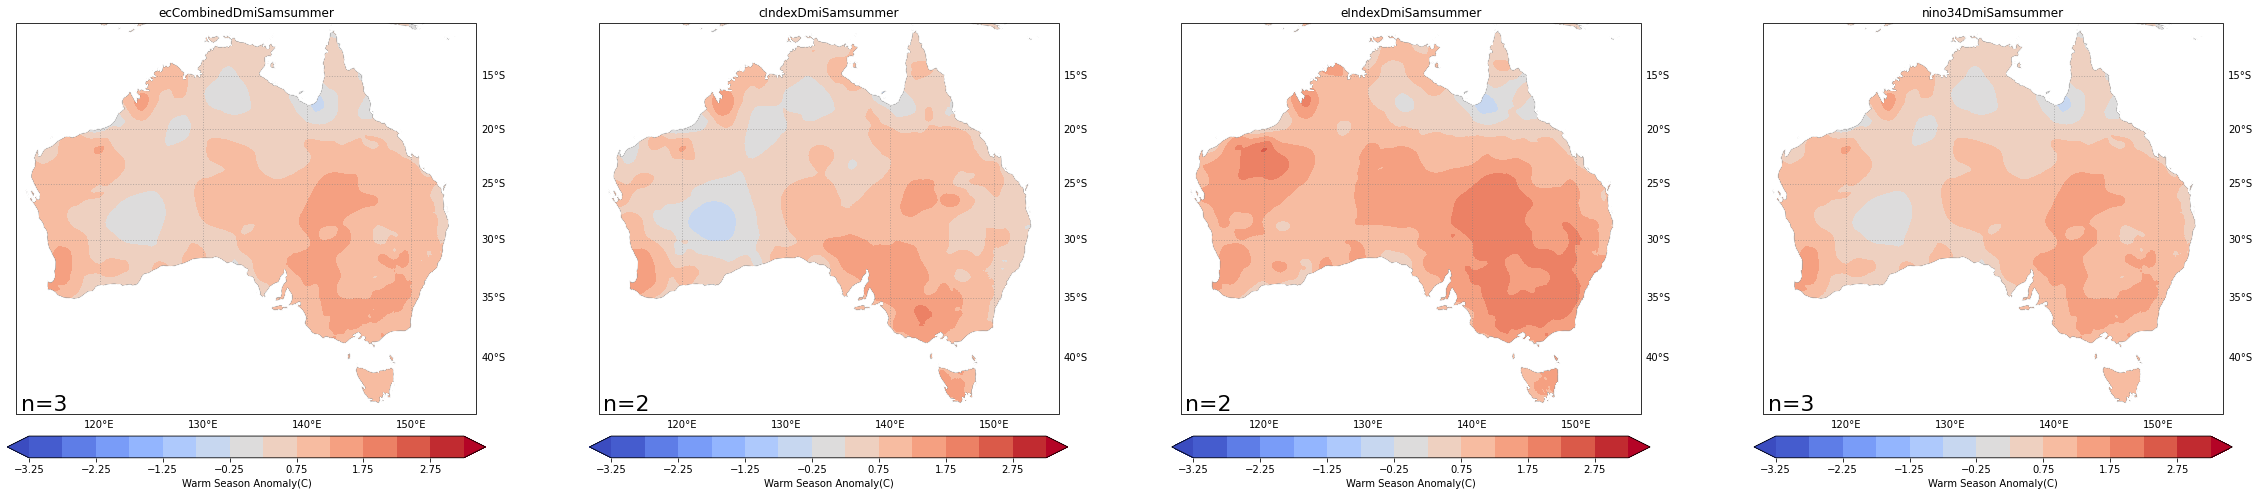

neg
winter


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


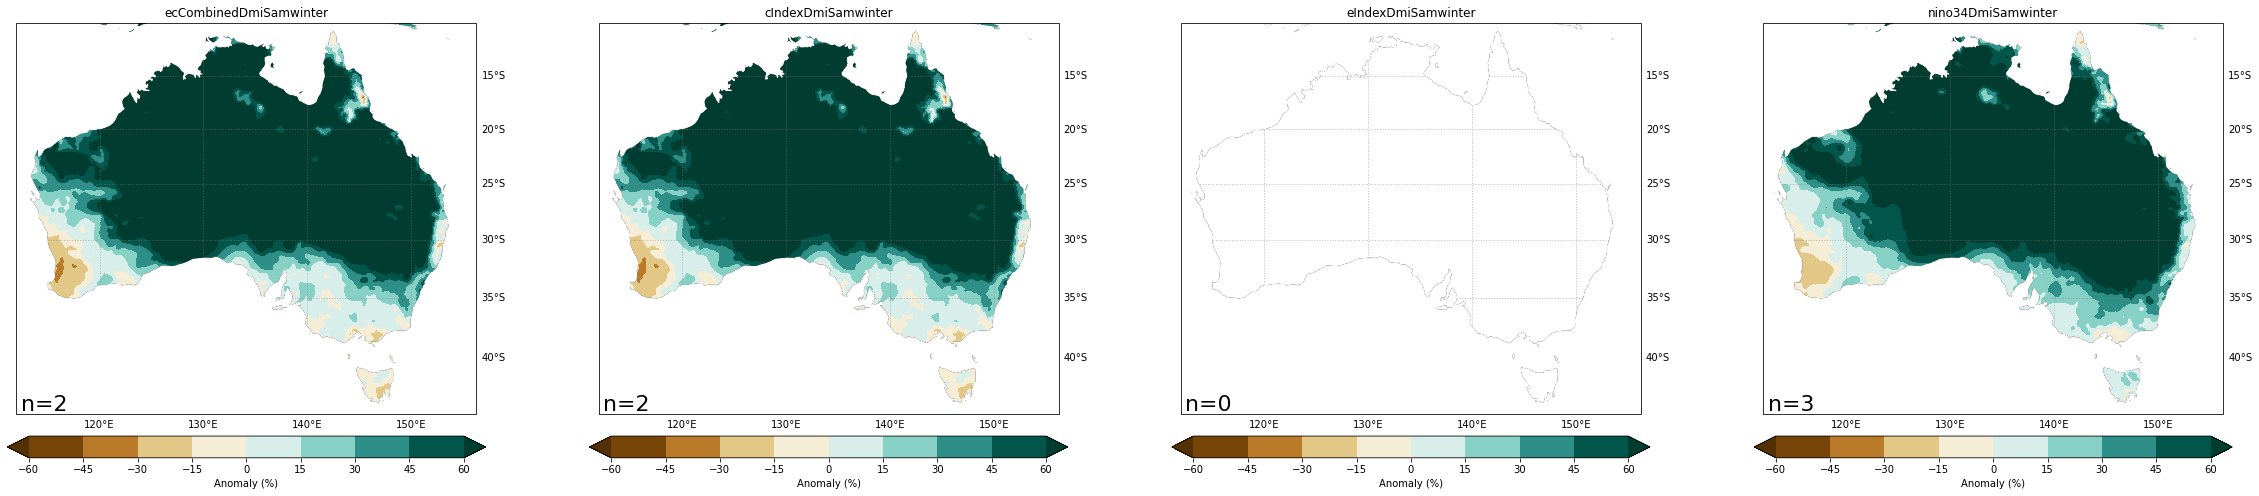

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


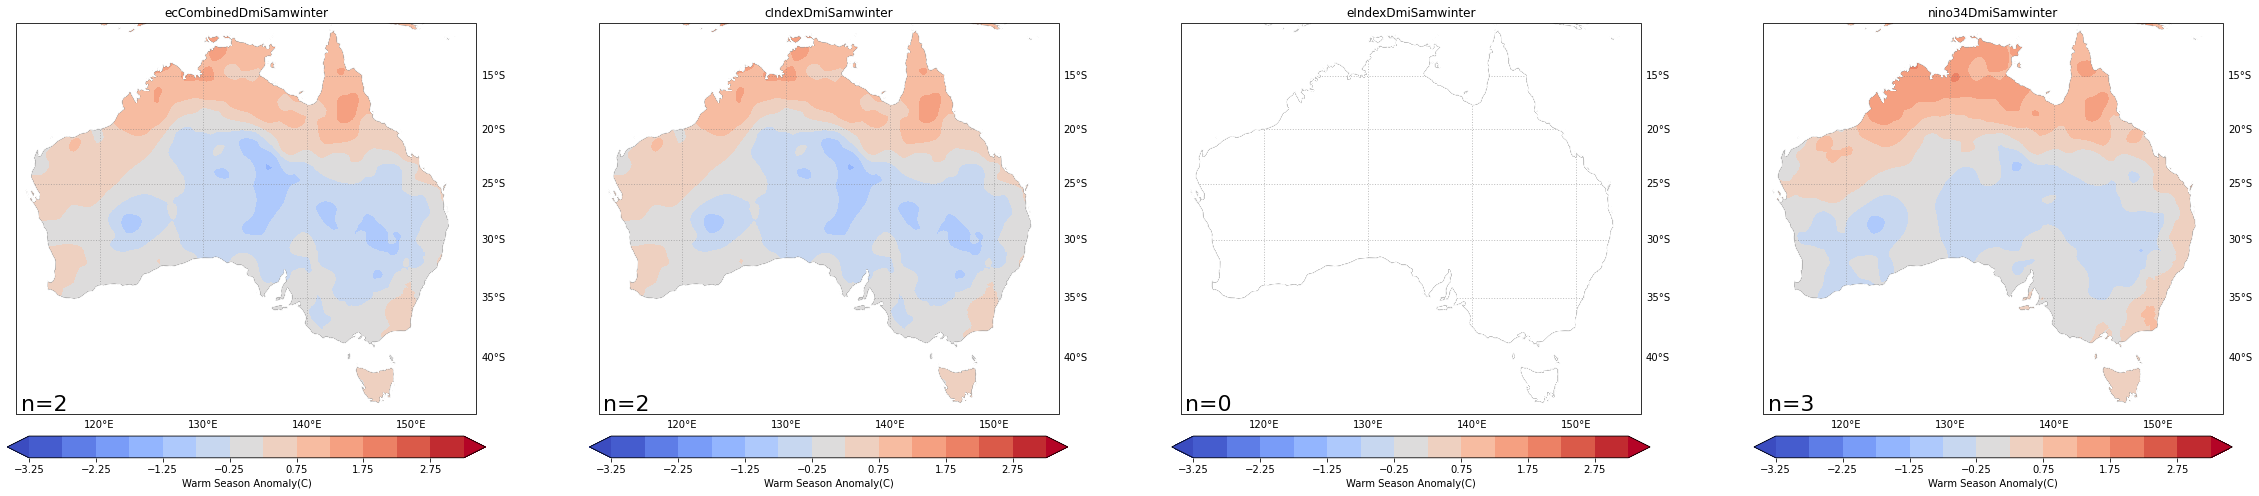

summer


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


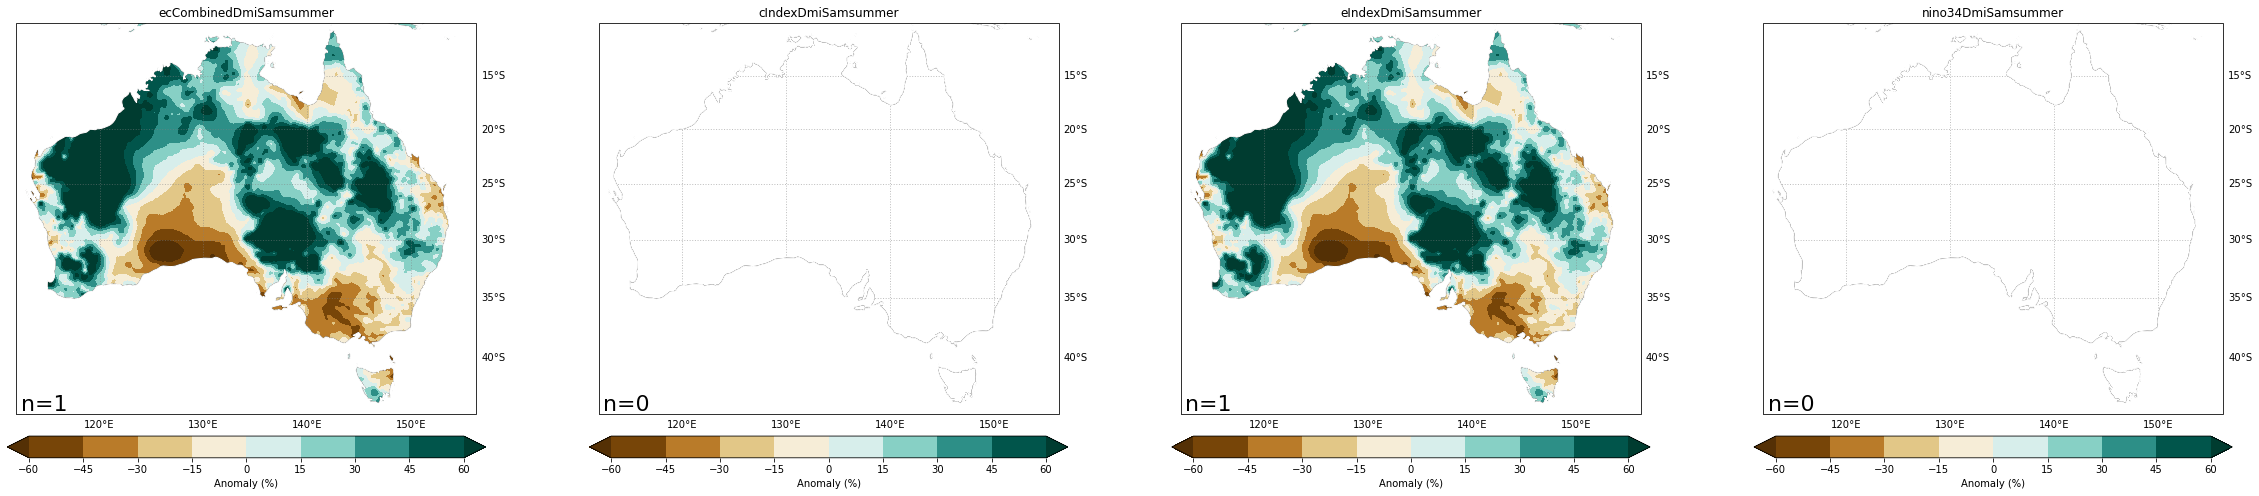

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


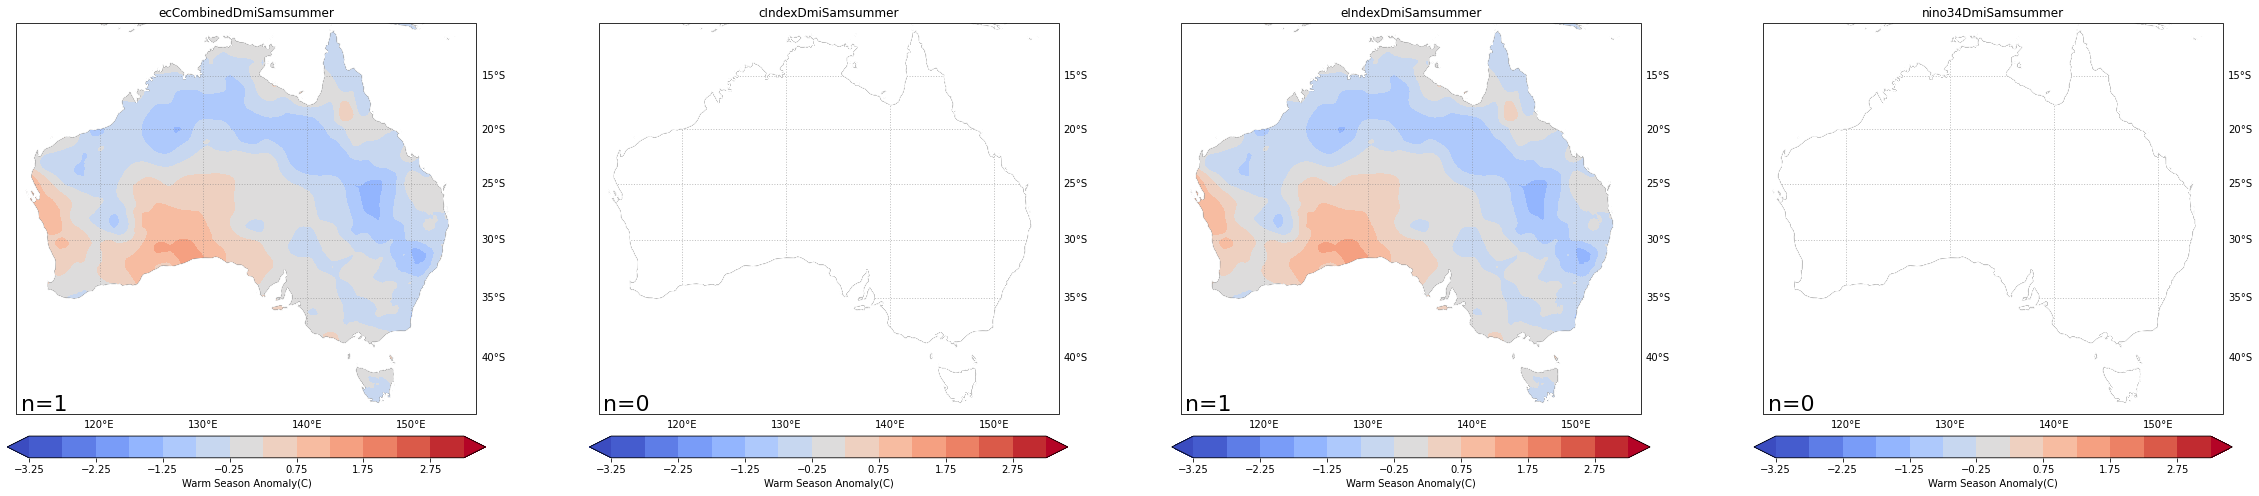

In [135]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()